In [732]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [733]:
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
            )
crime_df = pd.read_csv(data_path, header=1, index_col=False, skiprows=[0, 1, 2], skipfooter=3)

#Clean up the column names
crime_df.columns=['City','Population', 'Violent crime', 'Murder', 'Rape revised', 'Rape legacy', 'Robbery', 
         'Aggravated assault','Property crime', 'Burglary', 'Larceny', 'Motor vehicle theft', 'Arson']

#Turn the Population strings into integers
crime_df['Population'] = crime_df['Population'].str.replace(',', '')
crime_df['Population'] = crime_df['Population'].astype(int)
#Turn the Robbery strings into integers
crime_df['Robbery'] = crime_df['Robbery'].str.replace(',', '')
crime_df['Robbery'] = crime_df['Robbery'].astype(int)
#Turn the Violent crime strings into integers
crime_df['Violent crime'] = crime_df['Violent crime'].str.replace(',', '')
crime_df['Violent crime'] = crime_df['Violent crime'].astype(int)
#Turn the Aggravated Assault strings into integers
crime_df['Aggravated assault'] = crime_df['Aggravated assault'].str.replace(',', '')
crime_df['Aggravated assault'] = crime_df['Aggravated assault'].astype(int)
#Turn the Property crime strings into integers
crime_df['Property crime'] = crime_df['Property crime'].str.replace(',', '')
crime_df['Property crime'] = crime_df['Property crime'].astype(int)
#Turn the Burglary strings into integers
crime_df['Burglary'] = crime_df['Burglary'].str.replace(',', '')
crime_df['Burglary'] = crime_df['Burglary'].astype(int)
#Turn the Larceny strings into integers
crime_df['Larceny'] = crime_df['Larceny'].str.replace(',', '')
crime_df['Larceny'] = crime_df['Larceny'].astype(int)
#Turn the Motor vehicle theft strings into integers
crime_df['Motor vehicle theft'] = crime_df['Motor vehicle theft'].str.replace(',', '')
crime_df['Motor vehicle theft'] = crime_df['Motor vehicle theft'].astype(int)

#Combine the Rape Scenarios into one category
crime_df['Rape legacy'] = crime_df['Rape legacy'].str.replace(',', '')
crime_df['Rape legacy'] = crime_df['Rape legacy'].astype(int)
crime_df['Rape revised'] = crime_df['Rape revised'].replace([None], 0).astype(int)
crime_df['Rape legacy'] = crime_df['Rape legacy'].replace([None], 0)
crime_df['Rape combined'] = crime_df['Rape revised'] + crime_df['Rape legacy']

crime_df['Arson'] = crime_df['Arson'].replace([None], 0).astype(int)

#Make Murder and Robbery binary
threshold = 1
crime_df['Murder binary'] = np.where(crime_df['Murder'] >= threshold, 1,0)
crime_df['Robbery binary'] = np.where(crime_df['Robbery'] >= threshold, 1, 0)

crime_df.head(10)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,City,Population,Violent crime,Murder,Rape revised,Rape legacy,Robbery,Aggravated assault,Property crime,Burglary,Larceny,Motor vehicle theft,Arson,Rape combined,Murder binary,Robbery binary
0,Adams Village,1861,0,0,0,0,0,0,12,2,10,0,0,0,0,0
1,Addison Town and Village,2577,3,0,0,0,0,3,24,3,20,1,0,0,0,0
2,Akron Village,2846,3,0,0,0,0,3,16,1,15,0,0,0,0,0
3,Albany,97956,791,8,0,30,227,526,4090,705,3243,142,0,30,1,1
4,Albion Village,6388,23,0,0,3,4,16,223,53,165,5,0,3,0,1
5,Alfred Village,4089,5,0,0,0,3,2,46,10,36,0,0,0,0,1
6,Allegany Village,1781,3,0,0,0,0,3,10,0,10,0,0,0,0,0
7,Amherst Town,118296,107,1,0,7,31,68,2118,204,1882,32,3,7,1,1
8,Amityville Village,9519,9,0,0,2,4,3,210,16,188,6,1,2,0,1
9,Amsterdam,18182,30,0,0,0,12,18,405,99,291,15,0,0,0,1


In [734]:
#Double Check there is no missing data

def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
print(crime_df.apply(num_missing, axis=0))

Missing values per column:
City                   0
Population             0
Violent crime          0
Murder                 0
Rape revised           0
Rape legacy            0
Robbery                0
Aggravated assault     0
Property crime         0
Burglary               0
Larceny                0
Motor vehicle theft    0
Arson                  0
Rape combined          0
Murder binary          0
Robbery binary         0
dtype: int64


In [735]:
#Let's Remove New York since it far outnumbers other data
crime_df = crime_df[crime_df.City != 'New York']

In [736]:
#Let's pick variables that are fairly independent of each other that provide a high R-Squared

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime_df['Property crime'].values.reshape(-1, 1)
X = crime_df[['Population', 'Murder binary', 'Robbery binary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  3.43860764e-02   1.43473775e+01  -9.42521334e+01]]

Intercept: 
 [-108.42335403]

R-squared:
0.788942800091


In [737]:
crime14_df = pd.read_csv('FBI Crime Data 2014.csv', header=1, index_col=False, skiprows=[0, 1, 2], skipfooter=7)
crime14_df = crime14_df.drop('Unnamed: 13', axis=1)

#Clean up the column names
crime14_df.columns=['City','Population', 'Violent crime', 'Murder', 'Rape revised', 'Rape legacy', 'Robbery', 
         'Aggravated assault','Property crime', 'Burglary', 'Larceny', 'Motor vehicle theft', 'Arson']

crime14_df = crime14_df[crime14_df.City != 'New York4']
#Double Check there is no missing data

def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
print(crime14_df.apply(num_missing, axis=0))
print(crime14_df['Property crime'][pd.isnull(crime14_df['Property crime'])])


Missing values per column:
City                     0
Population               0
Violent crime            0
Murder                   0
Rape revised           142
Rape legacy            226
Robbery                  0
Aggravated assault       0
Property crime           1
Burglary                 0
Larceny                  1
Motor vehicle theft      0
Arson                    3
dtype: int64
364    NaN
Name: Property crime, dtype: object


/Users/bryancorder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [738]:
#Woodbury doesn't have our dependent variable, so we cut it out
crime14_df = crime14_df[crime14_df.City != 'Woodbury Town4, 5']

In [739]:
crime14_df['City'] = crime14_df['City'].str.replace('4', '')

In [740]:
#Turn the Population strings into integers
crime14_df['Population'] = crime14_df['Population'].str.replace(',', '')
crime14_df['Population'] = crime14_df['Population'].astype(int)
#Turn the Robbery strings into integers
crime14_df['Robbery'] = crime14_df['Robbery'].str.replace(',', '')
crime14_df['Robbery'] = crime14_df['Robbery'].astype(int)
#Turn the Violent crime strings into integers
crime14_df['Violent crime'] = crime14_df['Violent crime'].str.replace(',', '')
crime14_df['Violent crime'] = crime14_df['Violent crime'].astype(int)
#Turn the Aggravated Assault strings into integers
crime14_df['Aggravated assault'] = crime14_df['Aggravated assault'].str.replace(',', '')
crime14_df['Aggravated assault'] = crime14_df['Aggravated assault'].astype(int)
#Turn the Property crime strings into integers
crime14_df['Property crime'] = crime14_df['Property crime'].str.replace(',', '')
crime14_df['Property crime'] = crime14_df['Property crime'].astype(int)
#Turn the Burglary strings into integers
crime14_df['Burglary'] = crime14_df['Burglary'].str.replace(',', '')
crime14_df['Burglary'] = crime14_df['Burglary'].astype(int)
#Turn the Larceny strings into integers
crime14_df['Larceny'] = crime14_df['Larceny'].str.replace(',', '')
crime14_df['Larceny'] = crime14_df['Larceny'].astype(int)
#Turn the Motor vehicle theft strings into integers
crime14_df['Motor vehicle theft'] = crime14_df['Motor vehicle theft'].str.replace(',', '')
crime14_df['Motor vehicle theft'] = crime14_df['Motor vehicle theft'].astype(int)

#Combine the Rape Scenarios into one category
crime14_df['Rape revised'] = crime14_df['Rape revised'].replace([None], 0).astype(int)
crime14_df['Rape legacy'] = crime14_df['Rape legacy'].replace([None], 0).astype(int)


crime14_df['Rape combined'] = crime14_df['Rape revised'] + crime14_df['Rape legacy']

crime14_df['Arson'] = crime14_df['Arson'].replace([None], 0).astype(int)

#Make Murder and Robbery binary
threshold = 1
crime14_df['Murder binary'] = np.where(crime14_df['Murder'] >= threshold, 1,0)
crime14_df['Robbery binary'] = np.where(crime14_df['Robbery'] >= threshold, 1, 0)
crime14_df.head(10)

,City,Population,Violent crime,Murder,Rape revised,Rape legacy,Robbery,Aggravated assault,Property crime,Burglary,Larceny,Motor vehicle theft,Arson,Rape combined,Murder binary,Robbery binary
0,Adams Village,1851,0,0,0,0,0,0,11,1,10,0,0,0,0,0
1,Addison Town and Village,2568,2,0,0,0,1,1,49,1,47,1,0,0,0,1
2,Afton Village,820,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,Akron Village,2842,1,0,0,0,0,1,17,0,17,0,0,0,0,0
4,Albany,98595,802,8,54,0,237,503,3888,683,3083,122,12,54,1,1
5,Albion Village,5872,26,0,3,0,2,21,204,41,159,4,0,3,0,1
6,Alexandria Bay Village,1107,0,0,0,0,0,0,7,2,5,0,0,0,0,0
7,Alfred Village,4032,11,1,1,0,0,9,30,6,24,0,0,1,1,0
8,Altamont Village,1723,1,0,0,0,0,1,2,2,0,0,0,0,0,0
9,Amherst Town,118860,128,1,16,0,43,68,2066,176,1846,44,2,16,1,1


In [741]:
regr = linear_model.LinearRegression()
Y2 = crime14_df['Property crime'].values.reshape(-1, 1)
y_train = crime_df['Property crime'].values.reshape(-1, 1)
y_test = crime14_df['Property crime'].values.reshape(-1, 1)
x_train = crime_df[['Population', 'Murder binary', 'Robbery binary']]
x_test = crime14_df[['Population', 'Murder binary', 'Robbery binary']]
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
predictions = lm.predict(x_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print('\nCoefficients: \n', lm.coef_)
print('\nIntercept: \n', lm.intercept_)
print('\nR-squared:')


(347, 3) (347, 1)
(367, 3) (367, 1)

Coefficients: 
 [[  3.43860764e-02   1.43473775e+01  -9.42521334e+01]]

Intercept: 
 [-108.42335403]

R-squared:


Score: 0.7754919714751726


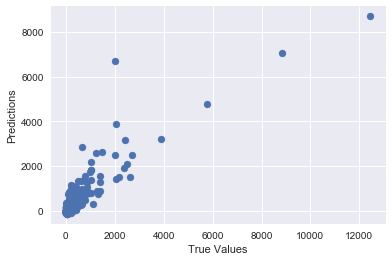

In [742]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print('Score: {}'.format(model.score(X_test, y_test)))

[ 0.77978464  0.54024739  0.25423227  0.81972977  0.34455211]


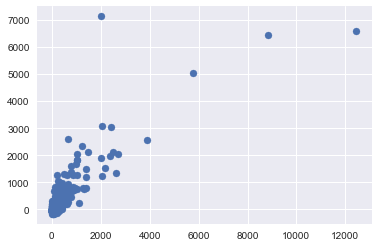

In [743]:
print(cross_val_score(model, X2, Y2, cv=5))
predictions = cross_val_predict(model, X2, Y2, cv=5)
plt.scatter(Y2, predictions)

In [744]:
accuracy = metrics.r2_score(Y2, predictions)
print('Cross-Predicted Accuracy:{}'.format(accuracy))

Cross-Predicted Accuracy:0.7093999640133559
